In [1]:
import scipy
from math import sqrt
from scipy import stats
from numpy import cov, linspace
from statistics import mean
from numpy.random import normal
import matplotlib.pyplot as plt
%matplotlib inline

## Overview and utility of CUPED

CUPED is a variance reduction technique introduced by Deng, Xu, Kohavi and Walker. Using CUPED we can achieve lower variance in A/B testing by computing an adjusted evaluation metric using historic "before" data. Based on blog posts, it seems that many big Internet companies are using CUPED, such as Bing, Facebook, Netflix, Booking, Etsy.

In this notebook we will use Monte Carlo simulations of A/B tests to demonstrate how CUPED works.

Experiment setup
Assume an A/B testing setup where we're measuring a metric M, eg. $ spend per user. We have N users, randomly split into A and B. A is control, B is treatment. We have metric M for each user for the "before" time period, when treatment and control was the same, and the "after" period, when treatment had some treatment applied, which we hope increased their spend.

Let Yi be the ith user's spend in the "after" period, and Xi be their spend in the "before" period, both for A and B combined. We compute an adjusted "after" spend Yadj

The CUPED recipe:

1. Compute the covariance of X and Y
2. Compute the variance of X
3. Compute the mean of X.
4. Compute the adjusted Y as Yadj = Y - (X-mean(X))*cov(X,Y)/var(X) for each user.
5. Evaluate the A/B test using Yadj



In [2]:
def get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, N):
    A_before = list(normal(loc=before_mean, scale=before_sigma, size=N))
    B_before = list(normal(loc=before_mean, scale=before_sigma, size=N))
    A_after  = [x + normal(loc=0, scale=eps_sigma) for x in A_before]
    B_after  = [x + normal(loc=0, scale=eps_sigma) + treatment_lift for x in B_before]
    return A_before, B_before, A_after, B_after

def get_cuped_adjusted(A_before, B_before, A_after, B_after):
    cv = cov([A_after + B_after, A_before + B_before])
    theta = cv[0, 1] / cv[1, 1]
    mean_before = mean(A_before + B_before)
    A_after_adjusted = [after - (before - mean_before) * theta for after, before in zip(A_after, A_before)]
    B_after_adjusted = [after - (before - mean_before) * theta for after, before in zip(B_after, B_before)]
    return A_after_adjusted, B_after_adjusted

def get_cuped_adjusted_lr(A_before, B_before, A_after, B_after):
    lr = stats.linregress(A_before + B_before, A_after + B_after)
    mean_after = mean(A_after + B_after)
    A_after_adjusted = [mean_after + after - (lr.intercept + before * lr.slope) for after, before in zip(A_after, A_before)]
    B_after_adjusted = [mean_after + after - (lr.intercept + before * lr.slope) for after, before in zip(B_after, B_before)]
    return A_after_adjusted, B_after_adjusted

def lift(A, B):
    return mean(B) - mean(A)

def expected_lift_ratio(A_before, B_before, A_after, B_after):
    cv = cov([A_after + B_after, A_before + B_before])
    corr = cv[0, 1] / (sqrt(cv[0, 0]) * sqrt(cv[1, 1]))
    return 1 - corr**2

def p_value(A, B):
    return stats.ttest_ind(A, B)[1]

A mean before = 096.5, A mean after = 096.5, A mean after adjusted = 098.3
B mean before = 100.1, B mean after = 102.9, B mean after adjusted = 101.1
Traditional    A/B test evaluation, lift = 6.383, p-value = 0.007
CUPED adjusted A/B test evaluation, lift = 2.805, p-value = 0.002


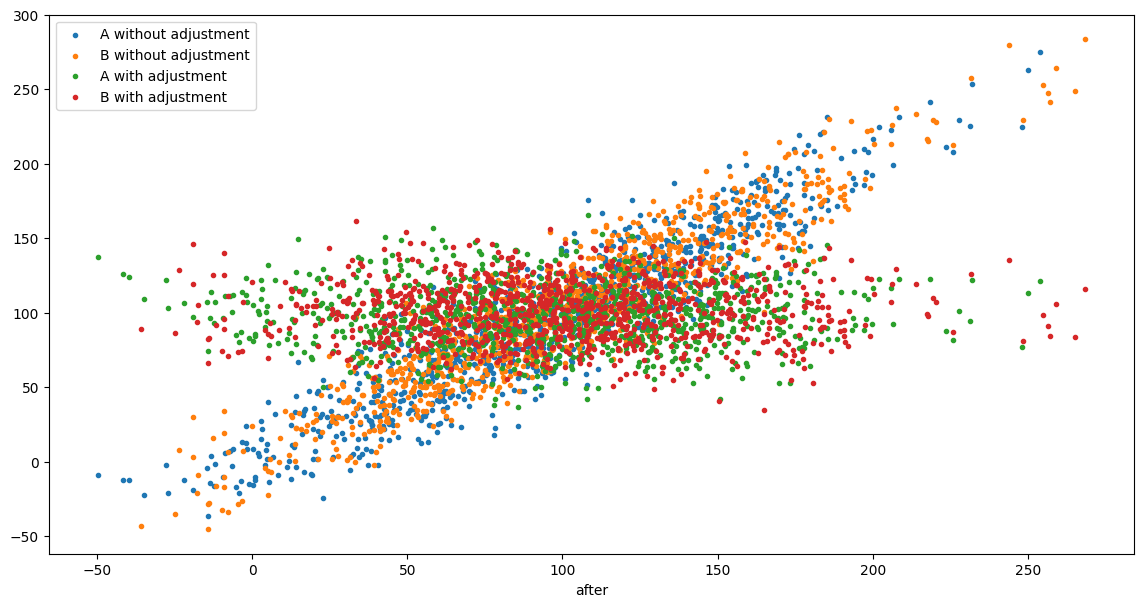

In [3]:
N = 1000
before_mean = 100 
before_sigma = 50
eps_sigma = 20
treatment_lift = 2

A_before, B_before, A_after, B_after = get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, N)
A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)

print('A mean before = %05.1f, A mean after = %05.1f, A mean after adjusted = %05.1f' % (mean(A_before), mean(A_after), mean(A_after_adjusted)))
print('B mean before = %05.1f, B mean after = %05.1f, B mean after adjusted = %05.1f' % (mean(B_before), mean(B_after), mean(B_after_adjusted)))
print('Traditional    A/B test evaluation, lift = %.3f, p-value = %.3f' % (lift(A_after, B_after), p_value(A_after, B_after)))
print('CUPED adjusted A/B test evaluation, lift = %.3f, p-value = %.3f' % (lift(A_after_adjusted, B_after_adjusted), p_value(A_after_adjusted, B_after_adjusted)))

plt.figure(figsize=(14, 7))
plt.scatter(A_before, A_after, marker='.')
plt.scatter(B_before, B_after, marker='.')
plt.scatter(A_before, A_after_adjusted, marker='.')
plt.scatter(B_before, B_after_adjusted, marker='.')
plt.xlabel('before')
plt.xlabel('after')
plt.legend(['A without adjustment', 'B without adjustment', 'A with adjustment', 'B with adjustment'])
plt.show()

Simulating 1000 A/B tests, true treatment lift is 2...
Traditional    A/B testing, mean lift = 2.00, variance of lift = 5.91
CUPED adjusted A/B testing, mean lift = 2.00, variance of lift = 0.73
CUPED lift variance / tradititional lift variance = 0.12 (expected = 0.14)


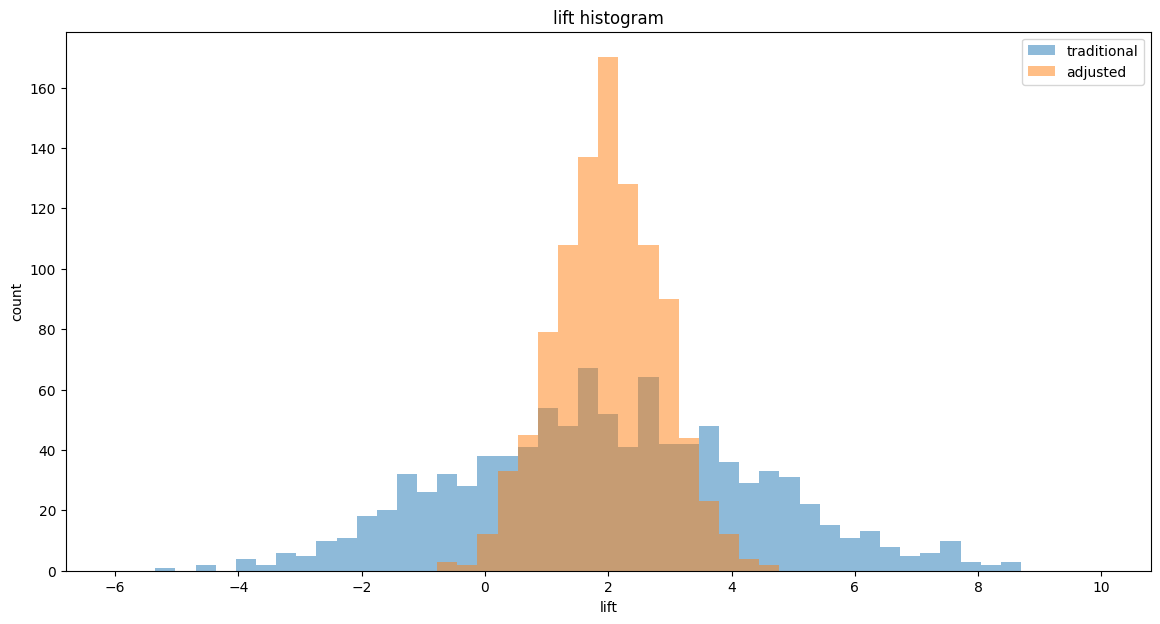

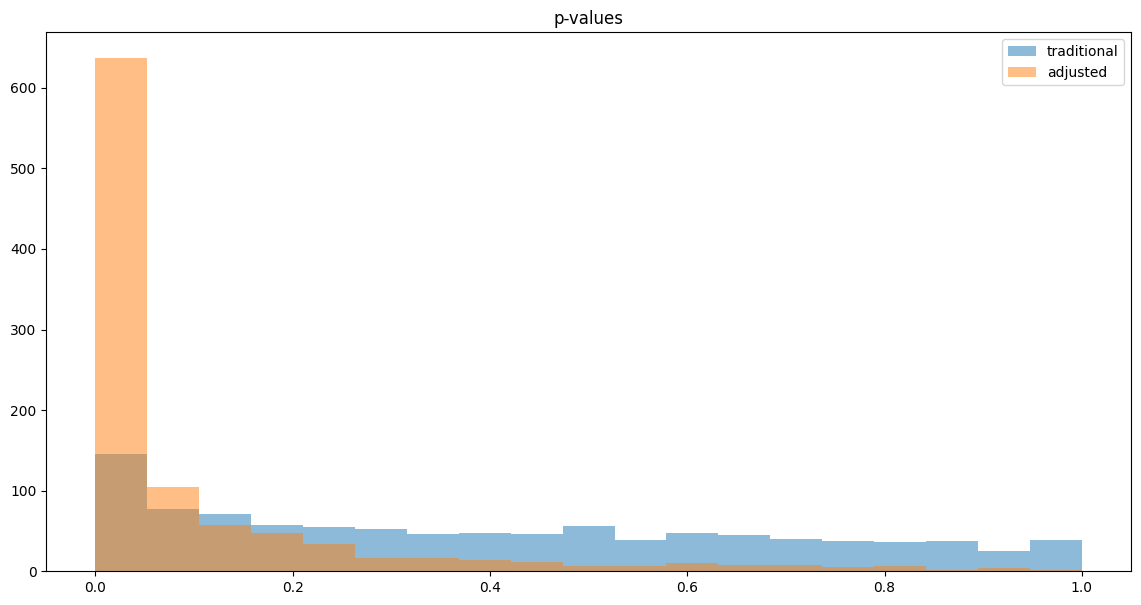

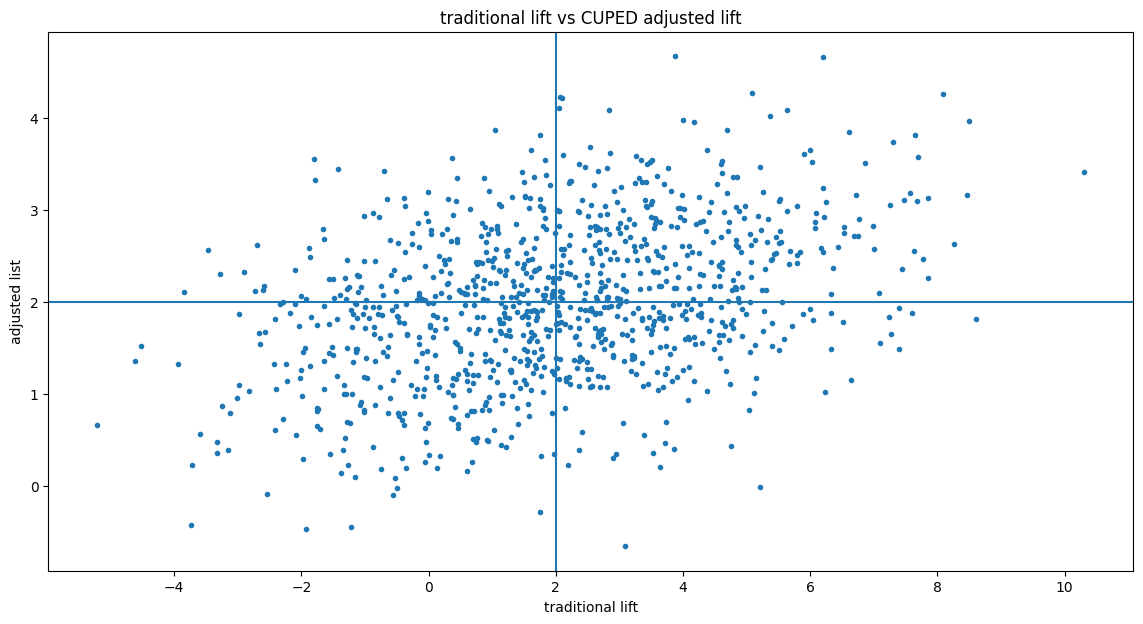

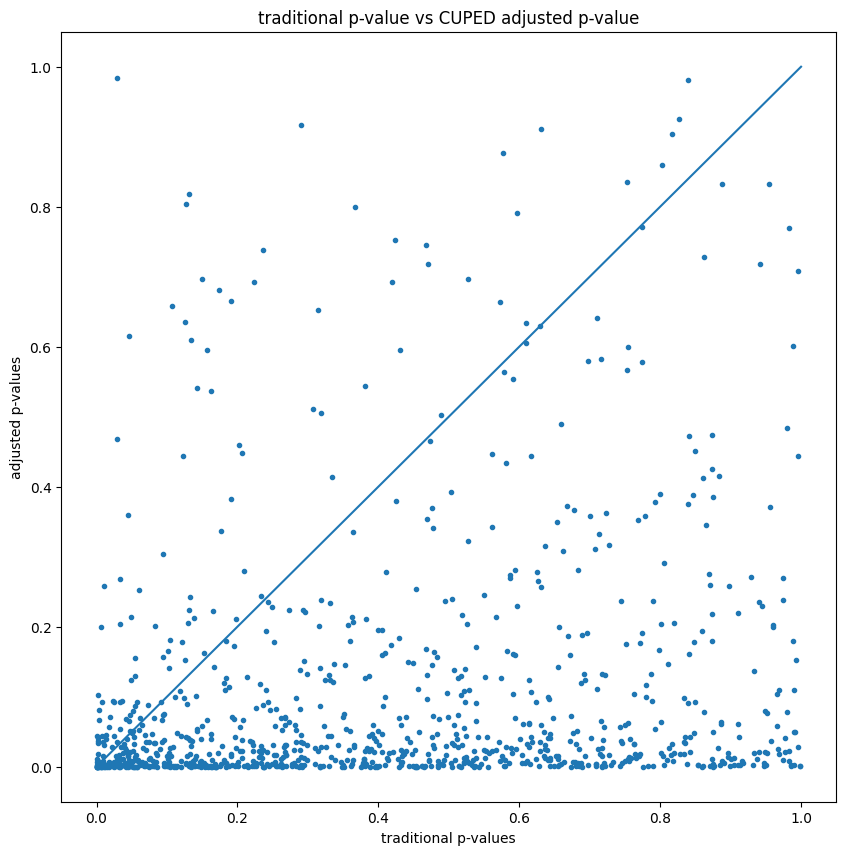

In [4]:
N = 1000
before_mean = 100 
before_sigma = 50
eps_sigma = 20
treatment_lift = 2
num_simulations = 1000

print('Simulating %s A/B tests, true treatment lift is %d...' % (num_simulations, treatment_lift))

traditional_lifts, adjusted_lifts = [], []
traditional_pvalues, adjusted_pvalues = [], []
for i in range(num_simulations):
    print('%d/%d' % (i, num_simulations), end='\r')
    A_before, B_before, A_after, B_after = get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, N)
    A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)
    traditional_lifts.append(lift(A_after, B_after))
    adjusted_lifts.append(lift(A_after_adjusted, B_after_adjusted))
    traditional_pvalues.append(p_value(A_after, B_after))
    adjusted_pvalues.append(p_value(A_after_adjusted, B_after_adjusted))
    
print('Traditional    A/B testing, mean lift = %.2f, variance of lift = %.2f' % (mean(traditional_lifts), cov(traditional_lifts)))
print('CUPED adjusted A/B testing, mean lift = %.2f, variance of lift = %.2f' % (mean(adjusted_lifts), cov(adjusted_lifts)))

large_N = 1000*1000
A_before, B_before, A_after, B_after = get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, large_N)
elr = expected_lift_ratio(A_before, B_before, A_after, B_after)
print('CUPED lift variance / tradititional lift variance = %.2f (expected = %.2f)' % (cov(adjusted_lifts)/cov(traditional_lifts), elr))

bins = linspace(-6, 10, 50)
plt.figure(figsize=(14, 7))
plt.hist(traditional_lifts, bins, alpha=0.5, label='traditional')
plt.hist(adjusted_lifts,    bins, alpha=0.5, label='adjusted')
plt.xlabel('lift')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('lift histogram')
plt.show()

bins = linspace(0, 1, 20)
plt.figure(figsize=(14, 7))
plt.hist(traditional_pvalues, bins, alpha=0.5, label='traditional')
plt.hist(adjusted_pvalues,    bins, alpha=0.5, label='adjusted')
plt.legend(loc='upper right')
plt.title('p-values')
plt.show()

plt.figure(figsize=(14, 7))
plt.scatter(traditional_lifts, adjusted_lifts, marker='.')
plt.xlabel('traditional lift')
plt.ylabel('adjusted list')
plt.axvline(x=treatment_lift)
plt.axhline(y=treatment_lift)
plt.title('traditional lift vs CUPED adjusted lift')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot([0,1],[0,1])
plt.scatter(traditional_pvalues, adjusted_pvalues, marker='.')
plt.xlabel('traditional p-values')
plt.ylabel('adjusted p-values')
plt.title('traditional p-value vs CUPED adjusted p-value')
plt.show()

Simulating 1000 A/B tests, true treatment lift is 2...
Traditional    A/B testing, mean lift = 1.97, variance of lift = 4.90
CUPED adjusted A/B testing, mean lift = 1.97, variance of lift = 4.90
CUPED lift variance / tradititional lift variance = 1.00


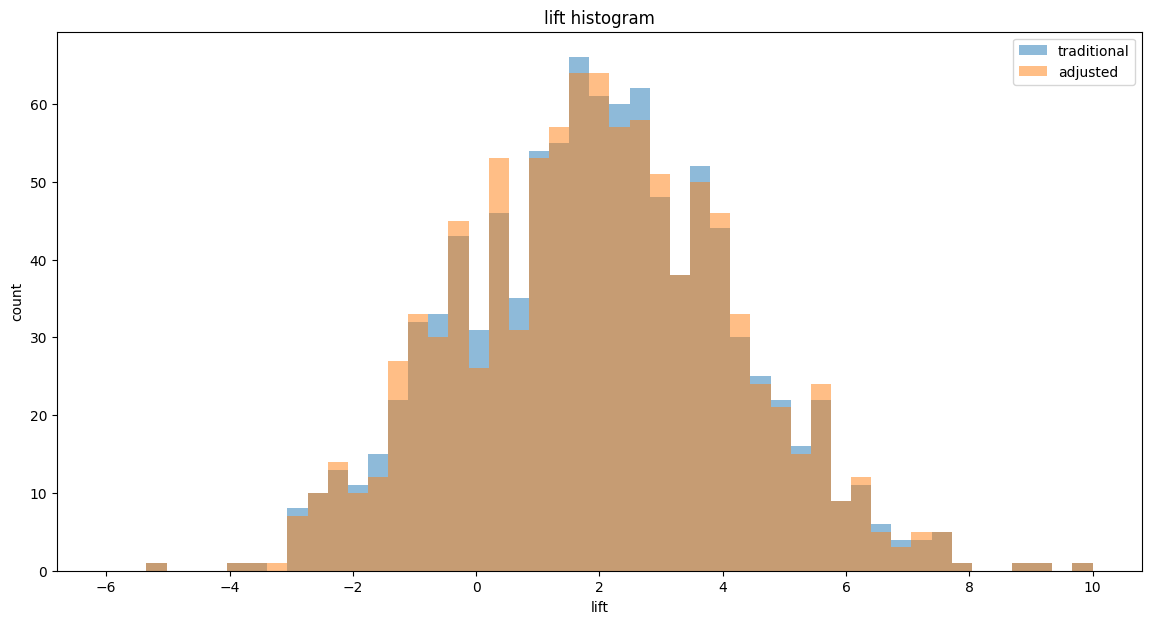

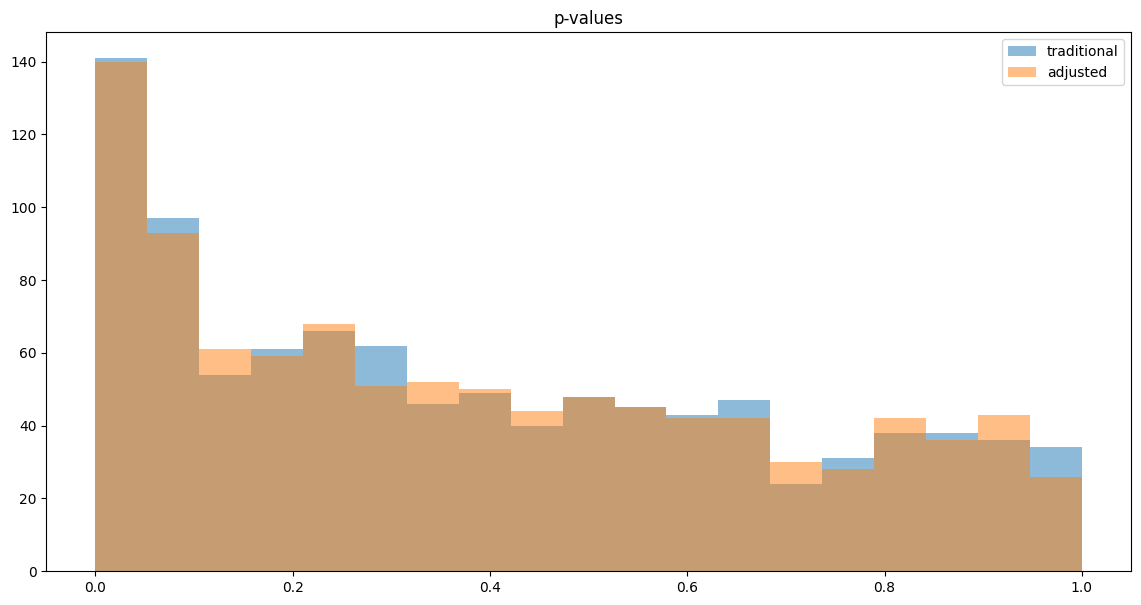

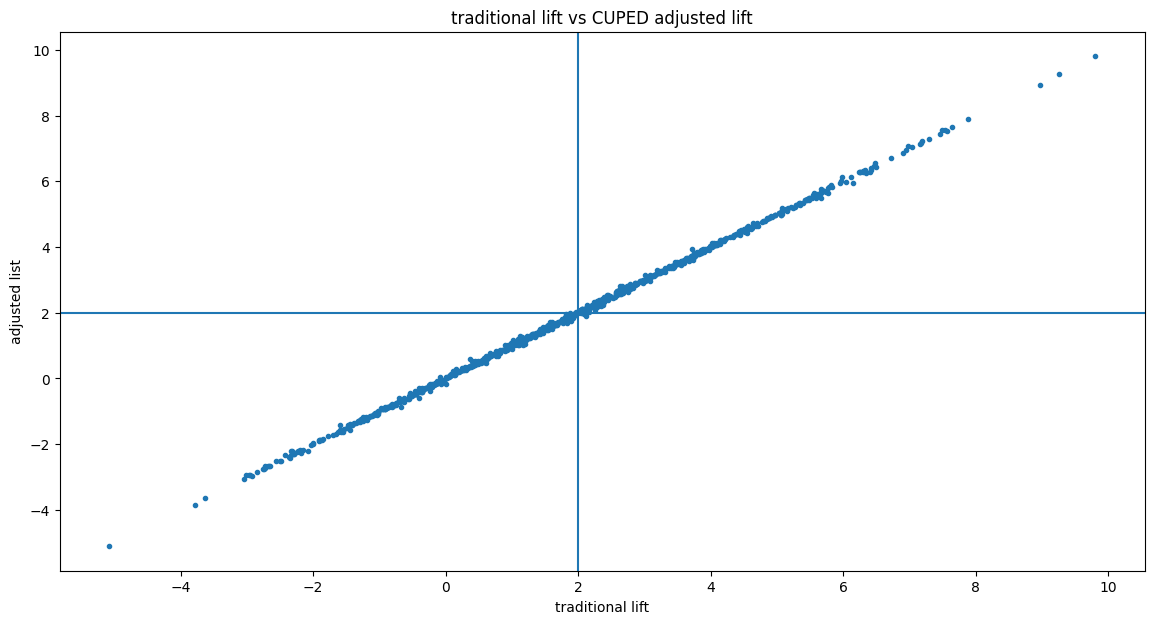

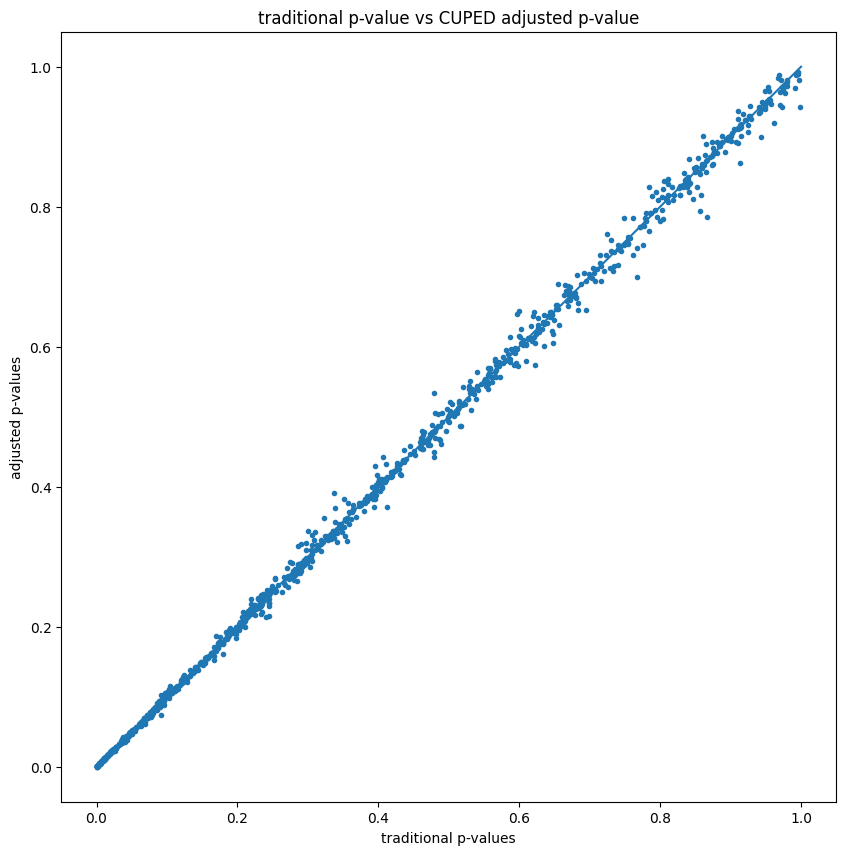

In [5]:
### no correlation

def get_AB_samples_nocorr(mu, sigma, treatment_lift, N):
    A_before = list(normal(loc=mu, scale=sigma, size=N))
    B_before = list(normal(loc=mu, scale=sigma, size=N))
    A_after  = list(normal(loc=mu, scale=sigma, size=N))
    B_after  = list(treatment_lift + normal(loc=mu, scale=sigma, size=N))
    return A_before, B_before, A_after, B_after

N = 1000
mu = 100 
sigma = 50
treatment_lift = 2
num_simulations = 1000

print('Simulating %s A/B tests, true treatment lift is %d...' % (num_simulations, treatment_lift))

traditional_lifts, adjusted_lifts = [], []
traditional_pvalues, adjusted_pvalues = [], []
for i in range(num_simulations):
    print('%d/%d' % (i, num_simulations), end='\r')
    A_before, B_before, A_after, B_after = get_AB_samples_nocorr(mu, sigma, treatment_lift, N)
    A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)
    traditional_lifts.append(lift(A_after, B_after))
    adjusted_lifts.append(lift(A_after_adjusted, B_after_adjusted))
    traditional_pvalues.append(p_value(A_after, B_after))
    adjusted_pvalues.append(p_value(A_after_adjusted, B_after_adjusted))
    
print('Traditional    A/B testing, mean lift = %.2f, variance of lift = %.2f' % (mean(traditional_lifts), cov(traditional_lifts)))
print('CUPED adjusted A/B testing, mean lift = %.2f, variance of lift = %.2f' % (mean(adjusted_lifts), cov(adjusted_lifts)))
print('CUPED lift variance / tradititional lift variance = %.2f' % (cov(adjusted_lifts)/cov(traditional_lifts)))

# large_N = 1000*1000
# A_before, B_before, A_after, B_after = get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, large_N)
# elr = expected_lift_ratio(A_before, B_before, A_after, B_after)
# print('CUPED lift variance / tradititional lift variance = %.2f (expected = %.2f)' % (cov(adjusted_lifts)/cov(traditional_lifts), elr))

bins = linspace(-6, 10, 50)
plt.figure(figsize=(14, 7))
plt.hist(traditional_lifts, bins, alpha=0.5, label='traditional')
plt.hist(adjusted_lifts,    bins, alpha=0.5, label='adjusted')
plt.xlabel('lift')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('lift histogram')
plt.show()

bins = linspace(0, 1, 20)
plt.figure(figsize=(14, 7))
plt.hist(traditional_pvalues, bins, alpha=0.5, label='traditional')
plt.hist(adjusted_pvalues,    bins, alpha=0.5, label='adjusted')
plt.legend(loc='upper right')
plt.title('p-values')
plt.show()

plt.figure(figsize=(14, 7))
plt.scatter(traditional_lifts, adjusted_lifts, marker='.')
plt.xlabel('traditional lift')
plt.ylabel('adjusted list')
plt.axvline(x=treatment_lift)
plt.axhline(y=treatment_lift)
plt.title('traditional lift vs CUPED adjusted lift')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot([0,1],[0,1])
plt.scatter(traditional_pvalues, adjusted_pvalues, marker='.')
plt.xlabel('traditional p-values')
plt.ylabel('adjusted p-values')
plt.title('traditional p-value vs CUPED adjusted p-value')
plt.show()